# Independent Work Project
The goal of this project is to use methods in data science to predict the probability that every player in the first round of the 2019 NBA draft makes an All-NBA team throughout their careers.

### Anaconda
We will use the Anaconda platform for Python for this project

In [93]:
%matplotlib inline

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

# Flags
include_woh  = False # Use Weight/Height instead of weight and height separately
include_pick = True  # Include the Pick No. as a feature

### Loading and preparing the data for analysis
The data consists of the college basketball statistics of all first round picks who have played in the NCAA, since the 1990 NBA Draft. The columns consist of:
* Points per game
* Rebounds per game
* Assists per game
* Steals per game
* etc.

In [94]:
# Loading data as Pandas dataframe
filename = 'data.csv' if include_woh else 'data_raw.csv'
df = pd.read_csv(filename, header=0)
if not include_pick: df = df.drop(['Pick'], axis=1)
df.head()

,Player,Pick #,RPG,APG,SPG,BPG,PPG,SOS,TS%,FTr,Height,Weight,Age,All-NBA
0,Derrick Coleman,1,12.1,2.9,1.5,2.0,17.9,8.85,0.620,0.747,82,230,23,1
1,Gary Payton,2,4.7,8.1,3.4,0.5,25.7,6.91,0.572,0.299,76,180,22,1
2,Mahmoud Abdul-Rauf,3,2.5,3.2,1.6,0.0,27.8,7.61,0.584,0.317,73,162,21,0
3,Dennis Scott,4,6.6,2.0,1.8,0.9,27.7,10.33,0.593,0.281,80,229,22,0
4,Kendall Gill,5,4.9,3.3,2.2,0.6,20.0,9.89,0.575,0.415,77,195,22,0


In [95]:
df = df._get_numeric_data()
headers = list(df.columns)
dataset = df.to_numpy()
y_i = headers.index('All-NBA')
    
# Separate data into features and target
x = dataset[:, 0:y_i]
y = dataset[:, y_i]

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=0)

# Predictive Models
We will use the following models for the following reasons...

## 1. Logistic Regression
Our first model will be a logistic regression model, using the default sklearn parameters.


In [96]:
log = Pipeline([
    ('scaler', StandardScaler()),
    ('RFE', RFE(LogisticRegression(solver='liblinear'))),
    ('LOG', LogisticRegression(solver='liblinear'))
])

log_os = Pipeline([
    ('scaler', StandardScaler()),
    ('OS', ADASYN(random_state=0)),
    ('RFE', RFE(LogisticRegression(solver='liblinear'))),
    ('LOG', LogisticRegression(solver='liblinear'))
])

n_features_to_select = [5,6,7,8]
penalty = ['l1', 'l2']
C = [0.001, 0.1, 1, 10, 100, 1000]

param_grid = [
    {
        'RFE__n_features_to_select': n_features_to_select,
        'LOG__penalty': penalty,
        'LOG__C': C
    }
]

model_log = GridSearchCV(log, param_grid=param_grid, cv=5, scoring='recall')
model_log_os = GridSearchCV(log_os, param_grid=param_grid, cv=5, scoring='recall')

## 2. Support Vector Classifier

In [97]:
svc = Pipeline([
    ('scaler', StandardScaler()),
    ('RFE', RFE(SVC(kernel='linear'))),
    ('SVC', SVC(kernel='linear', probability=True))
])

svc_os = Pipeline([
    ('scaler', StandardScaler()),
    ('OS', ADASYN(random_state=0)),
    ('RFE', RFE(SVC(kernel='linear'))),
    ('SVC', SVC(kernel='linear', probability=True))
])

n_features_to_select = [5,6,7,8]
gamma = [0.0001, 0.001, 0.01, 0.1, 1]
C = [0.0001, 0.001, 0.1, 1, 10, 100]

param_grid = [
    {
        'RFE__n_features_to_select': n_features_to_select,
        'SVC__gamma': gamma,
        'SVC__C': C
    }
]

model_svc = GridSearchCV(svc, param_grid=param_grid, cv=5, scoring='recall')
model_svc_os = GridSearchCV(svc_os, param_grid=param_grid, cv=5, scoring='recall')

## 3. Random Forest Classifier
For the Random Forest Classifier (RFC) we use randomized search with cross validation to achieve a shorter training time.

In [98]:
rfc = Pipeline([
    ('scaler', StandardScaler()),
    ('RFE', RFE(RandomForestClassifier())),
    ('RFC', RandomForestClassifier())  
])

rfc_os = Pipeline([
    ('scaler', StandardScaler()),
    ('OS', ADASYN(random_state=0)),
    ('RFE', RFE(RandomForestClassifier())),
    ('RFC', RandomForestClassifier())
])
                
param_grid = {
    'RFE__n_features_to_select': [6, 7, 8],
    'RFC__max_features': ['auto', 'sqrt'],
    'RFC__n_estimators': [70, 80, 90, 100]
}

model_rfc_os = GridSearchCV(rfc_os, param_grid=param_grid, cv=5, scoring='recall')
model_rfc = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='recall')

# Evaluating the Models
We will now look at a few methods of evaluating the models we've created

In [99]:
# Evaluation method
def evaluate(model, model_name, RFE=True):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    # Confusion matrix
    xlabels=['Predicted 0', 'Predicted 1']
    ylabels=['Actual 0', 'Actual 1']
    
    plt.subplot(121, aspect='equal')
    plt.title('Confusion Matrix - %s' % model_name)
    cm = confusion_matrix(y_test, pred)
    df_cm = pd.DataFrame(cm, range(2), range(2))
    ax = sn.heatmap(df_cm, annot=True, xticklabels=xlabels, yticklabels=ylabels, cbar=False)
    ax.set_ylim(2, 0) # workaround for cut-off bug
    
    # ROC Curve
    probs = model.predict_proba(x_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(122, aspect='equal')
    plt.title('ROC Curve - %s' % model_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.tight_layout()
    plt.savefig('./evals/'+model_name+'.png', dpi=250)
    plt.show()
    
    
    # Accuracy, recall, precision and F1, and best parameters
    print('Accuracy of "%s" model: %.3f' % (model_name, metrics.accuracy_score(y_test, pred)))
    print('Recall of "%s" model: %.3f' % (model_name, metrics.recall_score(y_test, pred)))
    print('Precision of "%s" model: %.3f' % (model_name, metrics.precision_score(y_test, pred)))
    print('F1 of "%s" model: %.3f' % (model_name, metrics.f1_score(y_test, pred)))
    
    # If the model used feature selection:
    if RFE:
        clf = model.best_estimator_ 
        
        print('\n')
        print('Hyperparameters:',model.best_params_)
        rfe = clf.named_steps['RFE']
        print('Selected features:',[headers[i] for i in rfe.get_support(indices=True)])

### Dummy Classifier
A dummy classifier assigns labels randomly, according to the distribution of classes in the training set

In [100]:
dummy = Pipeline([
    ('scaler', StandardScaler()),
    ('RFC', DummyClassifier(strategy='stratified'))
])
dummy_os = Pipeline([
    ('scaler', StandardScaler()),
    ('OS', ADASYN(random_state=10)),
    ('RFC', DummyClassifier(strategy='stratified'))
])

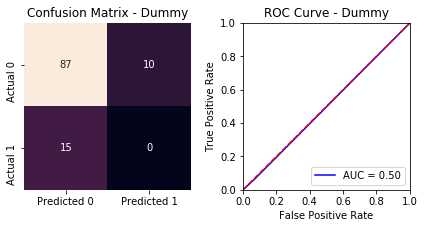

Accuracy of "Dummy" model: 0.777
Recall of "Dummy" model: 0.000
Precision of "Dummy" model: 0.000
F1 of "Dummy" model: 0.000


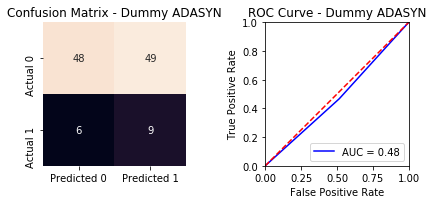

Accuracy of "Dummy ADASYN" model: 0.509
Recall of "Dummy ADASYN" model: 0.600
Precision of "Dummy ADASYN" model: 0.155
F1 of "Dummy ADASYN" model: 0.247


In [101]:
evaluate(dummy, 'Dummy', RFE=False)
evaluate(dummy_os, 'Dummy ADASYN', RFE=False)

## Logistic Regression
LOG model, with and without ADASYN oversampling

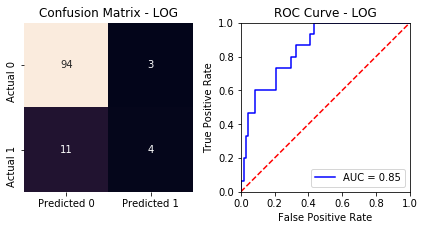

Accuracy of "LOG" model: 0.875
Recall of "LOG" model: 0.267
Precision of "LOG" model: 0.571
F1 of "LOG" model: 0.364


Hyperparameters: {'LOG__C': 10, 'LOG__penalty': 'l1', 'RFE__n_features_to_select': 5}
Selected features: ['Pick #', 'RPG', 'APG', 'Weight', 'Age']


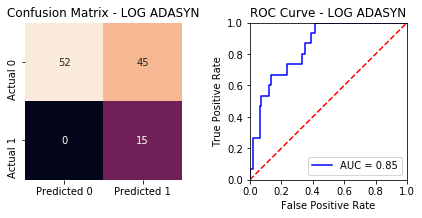

Accuracy of "LOG ADASYN" model: 0.598
Recall of "LOG ADASYN" model: 1.000
Precision of "LOG ADASYN" model: 0.250
F1 of "LOG ADASYN" model: 0.400


Hyperparameters: {'LOG__C': 0.001, 'LOG__penalty': 'l2', 'RFE__n_features_to_select': 5}
Selected features: ['Pick #', 'RPG', 'APG', 'Weight', 'Age']


In [102]:
evaluate(model_log, 'LOG')
evaluate(model_log_os, 'LOG ADASYN')

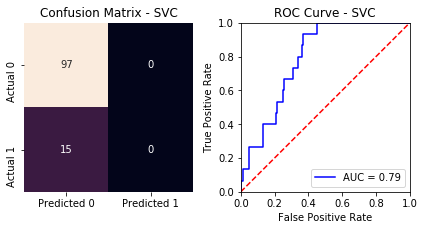

Accuracy of "SVC" model: 0.866
Recall of "SVC" model: 0.000
Precision of "SVC" model: 0.000
F1 of "SVC" model: 0.000


Hyperparameters: {'RFE__n_features_to_select': 5, 'SVC__C': 0.0001, 'SVC__gamma': 0.0001}
Selected features: ['Pick #', 'RPG', 'APG', 'Height', 'Age']


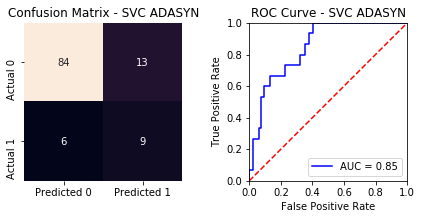

Accuracy of "SVC ADASYN" model: 0.830
Recall of "SVC ADASYN" model: 0.600
Precision of "SVC ADASYN" model: 0.409
F1 of "SVC ADASYN" model: 0.486


Hyperparameters: {'RFE__n_features_to_select': 7, 'SVC__C': 0.001, 'SVC__gamma': 0.0001}
Selected features: ['Pick #', 'RPG', 'APG', 'PPG', 'Height', 'Weight', 'Age']


In [103]:
evaluate(model_svc, 'SVC')
evaluate(model_svc_os, 'SVC ADASYN')

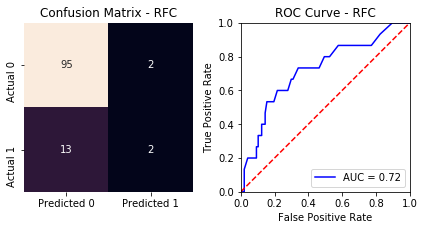

Accuracy of "RFC" model: 0.866
Recall of "RFC" model: 0.133
Precision of "RFC" model: 0.500
F1 of "RFC" model: 0.211


Hyperparameters: {'RFC__max_features': 'auto', 'RFC__n_estimators': 90, 'RFE__n_features_to_select': 6}
Selected features: ['Pick #', 'RPG', 'APG', 'SOS', 'TS%', 'Weight']


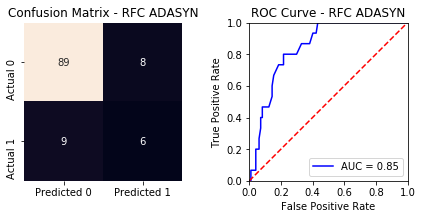

Accuracy of "RFC ADASYN" model: 0.848
Recall of "RFC ADASYN" model: 0.400
Precision of "RFC ADASYN" model: 0.429
F1 of "RFC ADASYN" model: 0.414


Hyperparameters: {'RFC__max_features': 'auto', 'RFC__n_estimators': 70, 'RFE__n_features_to_select': 8}
Selected features: ['Pick #', 'RPG', 'APG', 'SPG', 'BPG', 'SOS', 'FTr', 'Age']


In [104]:
evaluate(model_rfc, 'RFC')
evaluate(model_rfc_os, 'RFC ADASYN')

# Interpreting the Models

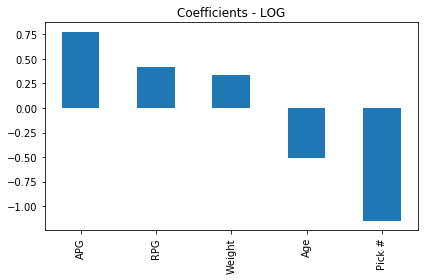

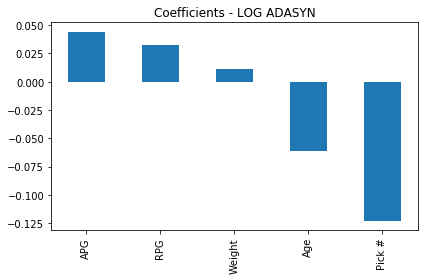

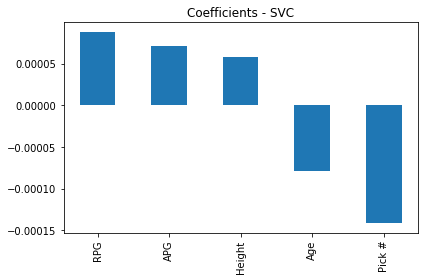

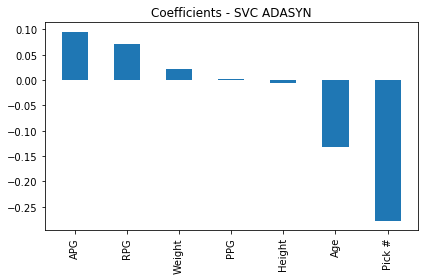

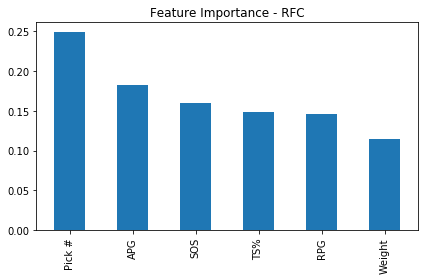

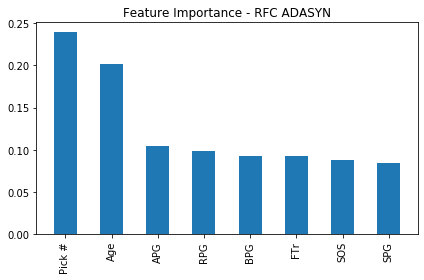

In [134]:
def analyze_features(model, clf_name, model_name):
    try:
        t = 'Feature Importance'
        a = model.named_steps[clf_name].feature_importances_
    except:
        t = 'Coefficients'
        a = model.named_steps[clf_name].coef_[0]
    
    # getting most important features
    rfe = model.named_steps['RFE']
    selected_features = [headers[i] for i in rfe.get_support(indices=True)]
    indices = np.argsort(a)[::-1]
    names = [selected_features[i] for i in indices]

    # Create plot
    plt.figure()
    plt.title(t+ " - "+model_name)
    plt.bar(range(len(a)), a[indices], width=0.5)
    plt.xticks(range(len(a)), names, rotation=90)
    plt.tight_layout()
    plt.savefig('./features/'+model_name+'.png', dpi=250)
    plt.show()

analyze_features(model_log.best_estimator_, 'LOG', 'LOG')
analyze_features(model_log_os.best_estimator_, 'LOG', 'LOG ADASYN')
analyze_features(model_svc.best_estimator_, 'SVC', 'SVC')
analyze_features(model_svc_os.best_estimator_, 'SVC', 'SVC ADASYN')
analyze_features(model_rfc.best_estimator_, 'RFC', 'RFC')
analyze_features(model_rfc_os.best_estimator_, 'RFC', 'RFC ADASYN')

# Results on 2019 Rookies

In [138]:
# Loading data as Pandas dataframe
filename = 'rookies.csv' if include_woh else 'rookies_raw.csv'
df = pd.read_csv(filename, header=0)
if not include_pick: df = df.drop(['Pick'], axis=1)
stats = df._get_numeric_data()
rookies = stats.to_numpy()

def pred_rookies(model, model_name):
    preds = [a[1] for a in model.predict_proba(rookies)]

    plt.figure()
    plt.title("Probabilities for 2019 rookies - "+model_name)
    plt.bar(range(len(preds)), preds, color='#ff8742', edgecolor='#000000')
    plt.xticks(range(len(preds)), df['Player'], rotation=90)
        
    plt.tight_layout()
    
    plt.savefig('./results/'+model_name+'.png', dpi=250)
    
    plt.show()

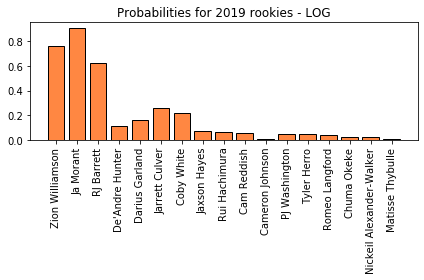

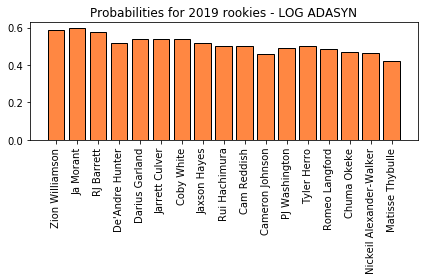

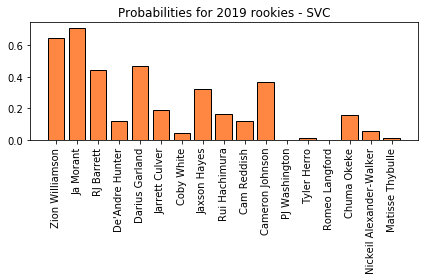

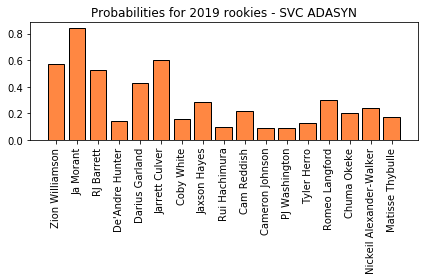

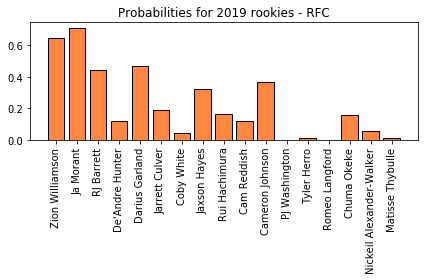

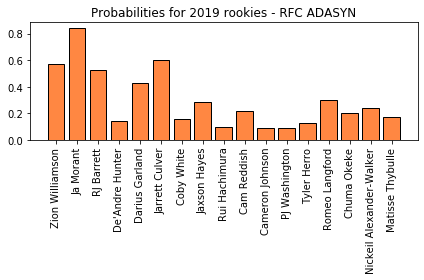

In [139]:
pred_rookies(model_log, "LOG")
pred_rookies(model_log_os, "LOG ADASYN")
pred_rookies(model_rfc, "SVC")
pred_rookies(model_rfc_os, "SVC ADASYN")
pred_rookies(model_rfc, "RFC")
pred_rookies(model_rfc_os, "RFC ADASYN")

In [ ]:
text=[['a', 'b', 'c'],[1, 2, 3]]
